In [1]:
from collections import defaultdict, Counter
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline

Using TensorFlow backend.


In [2]:
train = pd.read_hdf('../../../input/train_online_retail.h5')
test = pd.read_hdf('../../../input/test_online_retail.h5')
df_all = pd.concat([train, test], sort=False)
del train, test
gc.collect()

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 12 to 541893
Data columns (total 11 columns):
invoice         1067371 non-null int32
stock_code      1067371 non-null int16
description     1062989 non-null object
quantity        1067371 non-null int32
invoice_date    1067371 non-null datetime64[ns]
price_unit      1067371 non-null float16
price_total     1067371 non-null float32
customer_id     1067371 non-null int16
country         1067371 non-null object
is_canceled     520142 non-null object
is_test         1067371 non-null bool
dtypes: bool(1), datetime64[ns](1), float16(1), float32(1), int16(2), int32(2), object(3)
memory usage: 60.1+ MB


In [3]:
def group_to_dict(group_key, agg_func):
    train = df_all[ ~df_all['is_canceled'].isnull()]
    dict_ = train.groupby(group_key)['is_canceled'].agg(agg_func).to_dict()
    if -1 in dict_: del dict_[-1]
        
    mean = np.mean( list(dict_.values()) )
    return defaultdict(lambda: mean, dict_)

In [4]:
train = df_all[ ~df_all['is_canceled'].isnull()]
description_canc = train.groupby(['stock_code', 'description'])['is_canceled'].agg(np.sum).reset_index()
description_canc['is_canceled'] = description_canc['is_canceled'].astype(int)
description_canc['description'] = description_canc['description'].map(lambda x: str(x).strip())
description_canc['words'] = description_canc['description'].map(lambda x: x.split(' '))

most_canceled_words = {}
for i in range(description_canc.shape[0]):
    word_lst = description_canc['words'].iloc[i]    
    for word in word_lst:
        curr_num = most_canceled_words.get(word, 0)
        
        most_canceled_words[word] = curr_num + description_canc['is_canceled'].iloc[i]

#sorted(most_canceled_words.items() ,  key=lambda x: x[1], reverse=True)

words_to_del = []
for word in most_canceled_words.keys():
    if len(word) <= 2:
        words_to_del.append(word)
for word in words_to_del:
    del most_canceled_words[word]
    
most_canceled_words = defaultdict(lambda: 0, most_canceled_words)

stock_code_word_score = {}
for i in range(description_canc.shape[0]):
    word_lst = description_canc['words'].iloc[i]
    stock_score = 0
    for word in word_lst:
        stock_score += most_canceled_words[word]
        
    stock_code_word_score[description_canc['stock_code'].iloc[i]] = stock_score
    
stock_code_word_score = defaultdict(lambda: 0, stock_code_word_score)


In [5]:
# customer feats
df_all['cnt_customer_orders'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.size))
df_all['cnt_customer_cancel'] = df_all['customer_id'].map(group_to_dict('customer_id', agg_func=np.sum))
df_all['prc_customer_cancel'] = df_all[['cnt_customer_orders', 'cnt_customer_cancel']].apply(lambda x: x['cnt_customer_cancel'] / x['cnt_customer_orders'] if x['cnt_customer_orders'] != 0 else 0, axis=1)

# produkt feats
df_all['cnt_product_orders'] = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.size))
df_all['cnt_product_cancel'] = df_all['stock_code'].map(group_to_dict('stock_code', agg_func=np.sum))
df_all['prc_product_cancel'] = df_all[['cnt_product_orders', 'cnt_product_cancel']].apply(lambda x: x['cnt_product_cancel'] / x['cnt_product_orders'] if x['cnt_product_orders'] != 0 else 0, axis=1)

# describsion feats
df_all['stock_word_score'] = df_all['stock_code'].map(stock_code_word_score)

# date feats
df_all['invoice_year'] = df_all['invoice_date'].dt.year
df_all['invoice_month'] = df_all['invoice_date'].dt.month
df_all['invoice_day_of_m'] = df_all['invoice_date'].dt.day
df_all['invoice_day_of_y'] = df_all['invoice_date'].dt.dayofyear
df_all['invoice_hour'] = df_all['invoice_date'].dt.hour

# category feats
df_all['country__cat'] = pd.factorize(df_all['country'])[0]

# Train

In [6]:
def get_feats_X_y(df):
    
    # select feats
    black_list = ['is_canceled', 'is_test', 'total_return', 'is_canceled_pred', 'total_return', 'total_return_pred']
    feats = df.select_dtypes([np.bool, np.number]).columns
    feats = [x for x in feats if x not in black_list]

    feats = [x for x in feats if x + '_log' not in df.columns]
                  
    X = df[feats].values
    
#     if group:
#         if 'total_return_log' in df.columns:
#             y = df['total_return_log'].values 
#         else:
#             y = df['total_return'].values
#     else:
    y = df['is_canceled'].values
    
    return X, y, feats

In [7]:
def test_model(model, scoring='f1', check_distribution=False):
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    print('scores: {}'.format(scores))
    print('mean: {}, std: {} \n'.format(np.mean(scores), np.std(scores)))
    
    if check_distribution:
        y_pred = pd.Series(cross_val_predict(model, X, y, cv=cv))
        print('y_pred value_counts: \n{}'.format(y_pred.value_counts(normalize=True)))

        
        
def plot_model_char(model, check_confusion=True, check_feature_importance=True, check_learning_curve=True):
    
    if check_confusion:
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        y_pred = cross_val_predict(model, X, y, cv=cv)
        skplt.metrics.plot_confusion_matrix(y, y_pred, normalize=True, figsize=(10 ,10))
    
    if check_feature_importance or check_learning_curve:
        model.fit(X, y)
    
    if check_feature_importance:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    
    if check_learning_curve:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='recall');

In [8]:
# prepare to train
train = df_all[ ~df_all['is_test'] ].copy()
test = df_all[ df_all['is_test'] ].copy()

#release memory
del df_all
gc.collect()

train['cnt_product_cancel'] = train['cnt_product_cancel'].astype(float)
train['cnt_customer_cancel'] = train['cnt_customer_cancel'].astype(float)

test['cnt_product_cancel'] = test['cnt_product_cancel'].astype(float)
test['cnt_customer_cancel'] = test['cnt_customer_cancel'].astype(float)

train['is_canceled'] = train['is_canceled'].astype(bool)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 24 columns):
invoice                520142 non-null int32
stock_code             520142 non-null int16
description            517903 non-null object
quantity               520142 non-null int32
invoice_date           520142 non-null datetime64[ns]
price_unit             520142 non-null float16
price_total            520142 non-null float32
customer_id            520142 non-null int16
country                520142 non-null object
is_canceled            520142 non-null bool
is_test                520142 non-null bool
cnt_customer_orders    520142 non-null float64
cnt_customer_cancel    520142 non-null float64
prc_customer_cancel    520142 non-null float64
cnt_product_orders     520142 non-null float64
cnt_product_cancel     520142 non-null float64
prc_product_cancel     520142 non-null float64
stock_word_score       520142 non-null int64
invoice_year           520142 non-null int64
invoice_

# Order aproach

In [10]:
train.head()

,invoice,stock_code,description,quantity,invoice_date,price_unit,price_total,customer_id,country,is_canceled,...,cnt_product_orders,cnt_product_cancel,prc_product_cancel,stock_word_score,invoice_year,invoice_month,invoice_day_of_m,invoice_day_of_y,invoice_hour,country__cat
12,2,12,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.949219,59.500000,1,United Kingdom,False,...,242.0,1.0,0.004132,0,2009,12,1,335,9,0
13,2,13,LOVE BUILDING BLOCK WORD,18,2009-12-01 09:06:00,5.449219,98.099998,1,United Kingdom,False,...,890.0,11.0,0.012360,159,2009,12,1,335,9,0
14,2,14,HOME BUILDING BLOCK WORD,3,2009-12-01 09:06:00,5.949219,17.850000,1,United Kingdom,False,...,1081.0,11.0,0.010176,183,2009,12,1,335,9,0
15,2,15,ASSORTED COLOUR BIRD ORNAMENT,16,2009-12-01 09:06:00,1.690430,27.040001,1,United Kingdom,False,...,1384.0,10.0,0.007225,0,2009,12,1,335,9,0
16,2,16,PEACE WOODEN BLOCK LETTERS,3,2009-12-01 09:06:00,6.949219,20.850000,1,United Kingdom,False,...,185.0,3.0,0.016216,243,2009,12,1,335,9,0


In [11]:
def group_orders(df, params_to_group_by, params_to_agg, agg_fun, label_in_df):
    orders = df.groupby(params_to_group_by)[params_to_agg].agg(agg_fun).reset_index()
    
    if label_in_df:
        orders['is_canceled'] = orders['is_canceled'].map(lambda x: True if x>0 else False)
#         orders['total_return'] = orders['price_total'] * orders['is_canceled']
    return orders

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520142 entries, 12 to 541909
Data columns (total 24 columns):
invoice                520142 non-null int32
stock_code             520142 non-null int16
description            517903 non-null object
quantity               520142 non-null int32
invoice_date           520142 non-null datetime64[ns]
price_unit             520142 non-null float16
price_total            520142 non-null float32
customer_id            520142 non-null int16
country                520142 non-null object
is_canceled            520142 non-null bool
is_test                520142 non-null bool
cnt_customer_orders    520142 non-null float64
cnt_customer_cancel    520142 non-null float64
prc_customer_cancel    520142 non-null float64
cnt_product_orders     520142 non-null float64
cnt_product_cancel     520142 non-null float64
prc_product_cancel     520142 non-null float64
stock_word_score       520142 non-null int64
invoice_year           520142 non-null int64
invoice_

In [13]:
# params_to_group_by = ['invoice', 'customer_id', 'invoice_year', 'invoice_day_of_y', 'invoice_hour']
# params_to_sum = ['price_total', 'is_canceled']
# params_to_mean = ['cnt_customer_orders',  'cnt_customer_cancel',  'prc_customer_cancel', 'cnt_product_orders', 'cnt_product_cancel', 'prc_product_cancel', 'stock_word_score']

In [14]:
params_to_group_by = ['invoice', 'customer_id', 'invoice_year', 'invoice_day_of_y', 'invoice_hour']
params_to_sum = ['stock_code', 'price_total', 'is_canceled']
params_to_mean = ['cnt_customer_orders',  'cnt_customer_cancel',  'prc_customer_cancel', 'cnt_product_orders', 'cnt_product_cancel', 'prc_product_cancel', 'stock_word_score']

In [15]:
train_group_sum = group_orders(train, params_to_group_by, params_to_sum, np.sum, True)
train_group_mean = group_orders(train, params_to_group_by, params_to_mean, np.mean, False)
test_group_sum = group_orders(test, params_to_group_by, params_to_sum, np.sum, False)
test_group_mean = group_orders(test, params_to_group_by, params_to_mean, np.mean, False)

In [16]:
# all agregations into one df
train_group = train_group_mean
test_group = test_group_mean

for param in params_to_sum:
    train_group[param] = train_group_sum[param]
    if param != 'is_canceled':
        test_group[param] = test_group_sum[param]

del train_group_sum, train_group_mean, test_group_sum, test_group_mean


In [17]:
train_group.head()

,invoice,customer_id,invoice_year,invoice_day_of_y,invoice_hour,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,prc_product_cancel,stock_word_score,stock_code,price_total,is_canceled
0,2,1,2009,335,9,366.0,30.0,0.081967,460.157895,5.578947,0.018126,410.315789,399.0,630.330017,False
1,3,2,2009,335,9,40.0,0.0,0.000000,291.260870,4.391304,0.020913,436.304348,943.0,310.750000,False
2,4,3,2009,335,9,498.0,3.0,0.006024,193.764706,1.941176,0.011923,647.705882,1037.0,2286.239990,False
3,5,4,2009,335,9,575.0,0.0,0.000000,423.947368,18.157895,0.026849,669.473684,1364.0,426.299988,False
4,8,6,2009,335,9,101.0,1.0,0.009901,411.217391,5.739130,0.009393,472.000000,2007.0,382.369995,False


In [18]:
feats_to_log = ['cnt_customer_orders', 'cnt_customer_cancel', 'cnt_product_orders', 'cnt_product_cancel', 'price_total']

for feat in feats_to_log:
    if feat in train_group.columns:
        train_group[feat + '_log'] = np.log1p(train_group[feat])
        if feat != 'total_return':
            test_group[feat + '_log'] = np.log1p(test_group[feat])

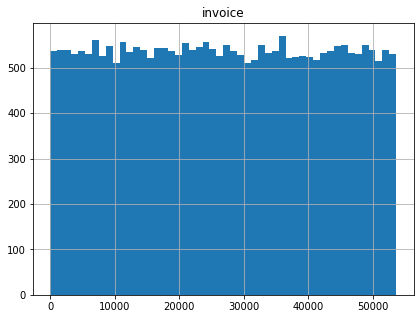

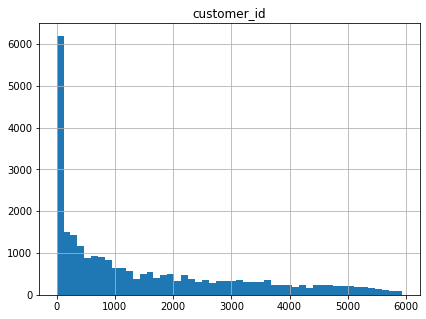

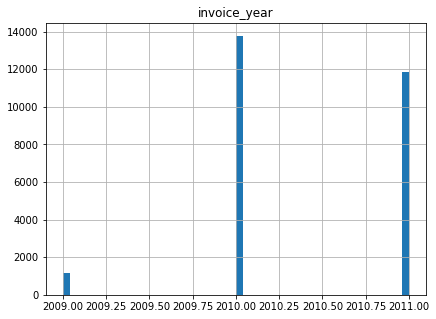

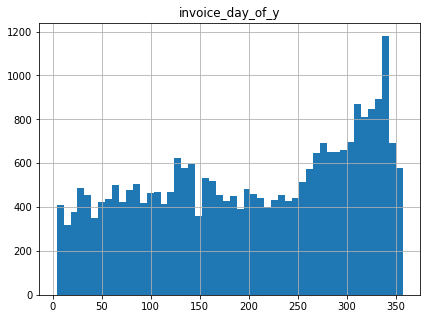

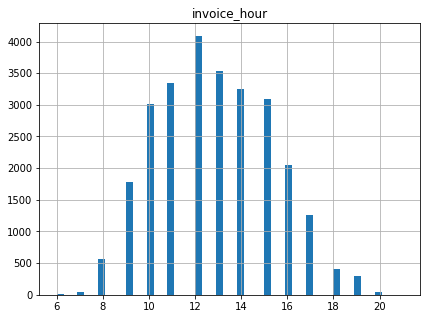

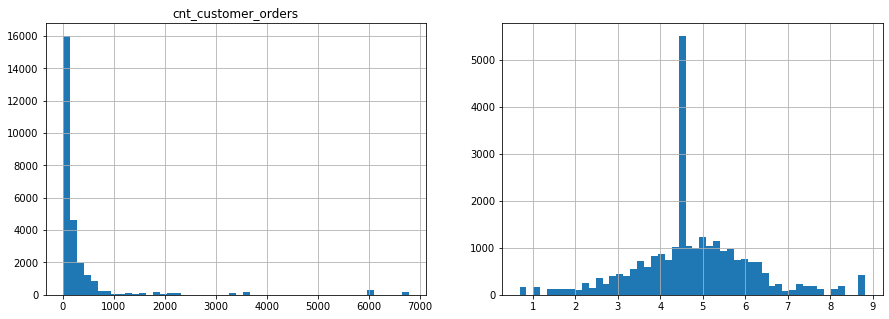

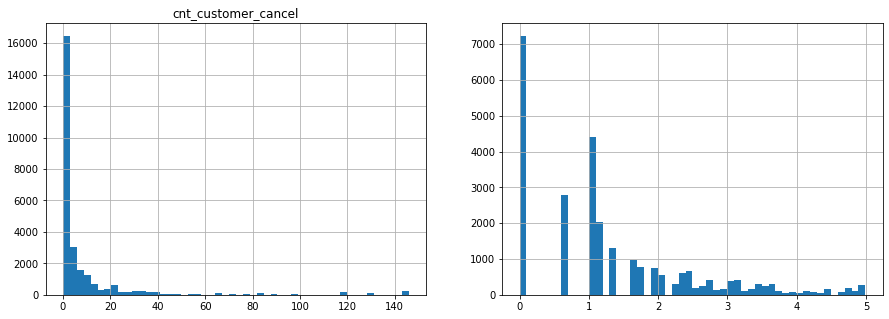

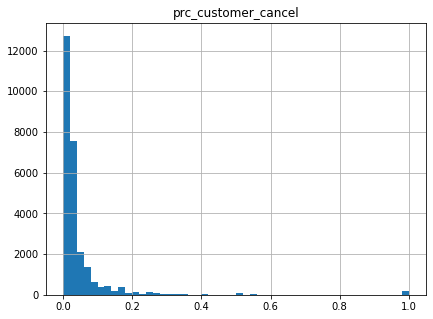

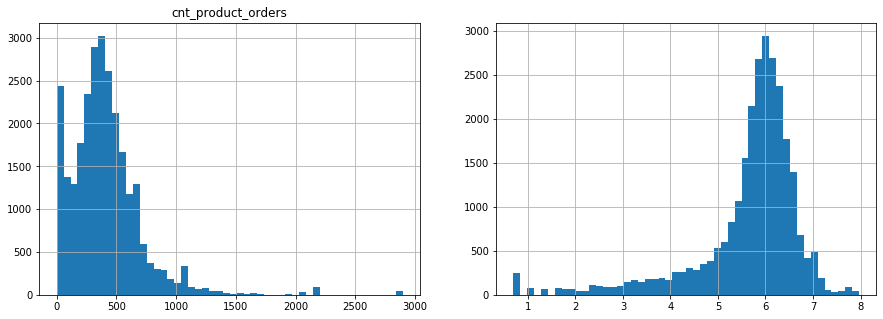

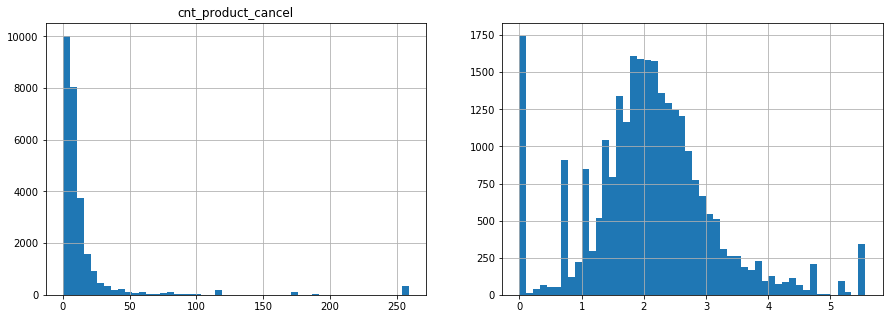

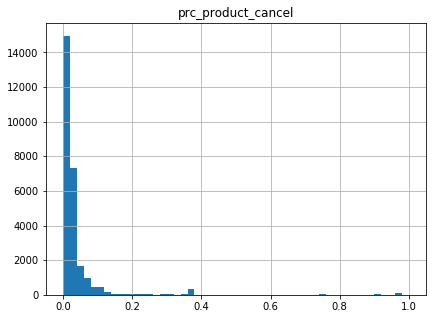

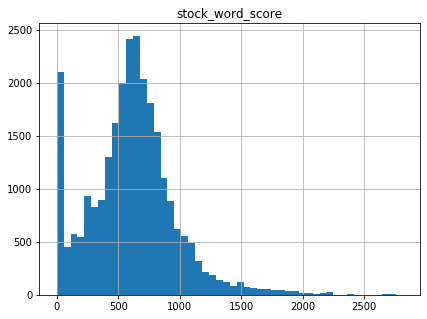

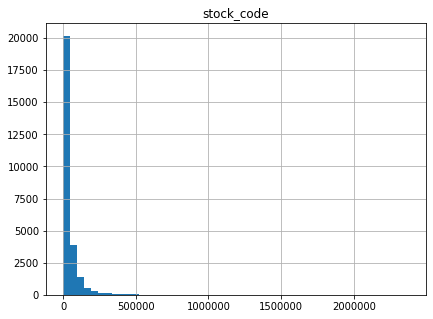

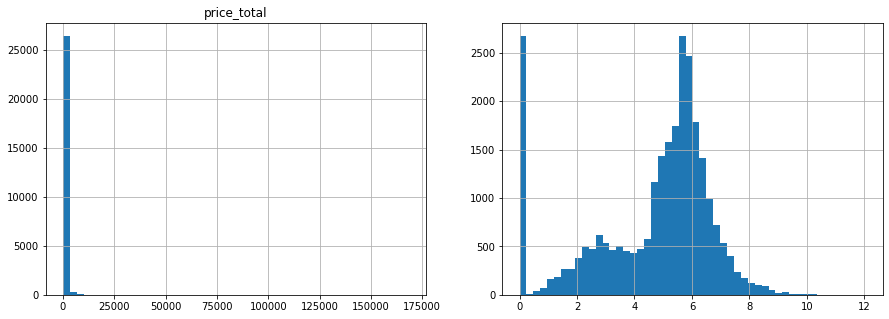

In [22]:
for feat in train_group.columns:
    if 'log' in feat or feat == 'is_canceled': continue
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    train_group[feat].hist(bins=50)
    plt.title(feat)
    if feat in feats_to_log:
        plt.subplot(1,2,2)
        np.log1p(train_group[feat]).hist(bins=50)    
    plt.show()

In [19]:
train_group.head()

,invoice,customer_id,invoice_year,invoice_day_of_y,invoice_hour,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,prc_product_cancel,stock_word_score,stock_code,price_total,is_canceled,cnt_customer_orders_log,cnt_customer_cancel_log,cnt_product_orders_log,cnt_product_cancel_log,price_total_log
0,2,1,2009,335,9,366.0,30.0,0.081967,460.157895,5.578947,0.018126,410.315789,399.0,630.330017,False,5.905362,3.433987,6.133740,1.883875,6.447829
1,3,2,2009,335,9,40.0,0.0,0.000000,291.260870,4.391304,0.020913,436.304348,943.0,310.750000,False,3.713572,0.000000,5.677647,1.684787,5.742202
2,4,3,2009,335,9,498.0,3.0,0.006024,193.764706,1.941176,0.011923,647.705882,1037.0,2286.239990,False,6.212606,1.386294,5.271792,1.078810,7.735101
3,5,4,2009,335,9,575.0,0.0,0.000000,423.947368,18.157895,0.026849,669.473684,1364.0,426.299988,False,6.356108,0.000000,6.051965,2.952715,6.057487
4,8,6,2009,335,9,101.0,1.0,0.009901,411.217391,5.739130,0.009393,472.000000,2007.0,382.369995,False,4.624973,0.693147,6.021551,1.907931,5.949000


In [23]:
X, y, feats = get_feats_X_y(train_group)
feats

['invoice',
 'customer_id',
 'invoice_year',
 'invoice_day_of_y',
 'invoice_hour',
 'prc_customer_cancel',
 'prc_product_cancel',
 'stock_word_score',
 'stock_code',
 'cnt_customer_orders_log',
 'cnt_customer_cancel_log',
 'cnt_product_orders_log',
 'cnt_product_cancel_log',
 'price_total_log']

In [24]:
xgb_params = {
    'max_depth' : 5,
    'n_estimators' : 50,
    'learning_rate': 0.1,
    'seed': 0
}
model = XGBClassifier(**xgb_params)
X, y, feats = get_feats_X_y(train_group)
test_model(model)

scores: [0.85755292 0.85531005 0.86051502]
mean: 0.8577926652145554, std: 0.0021316721189055185 



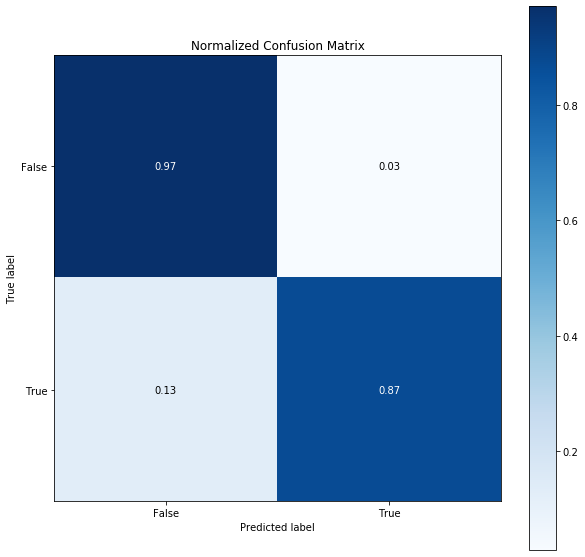

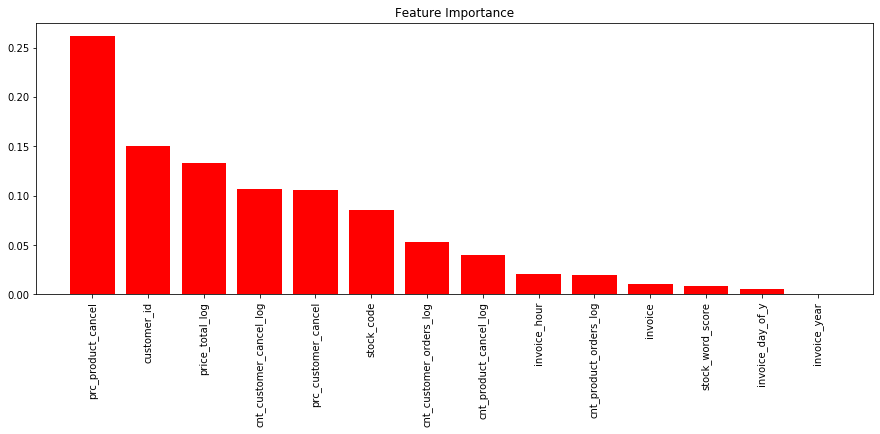

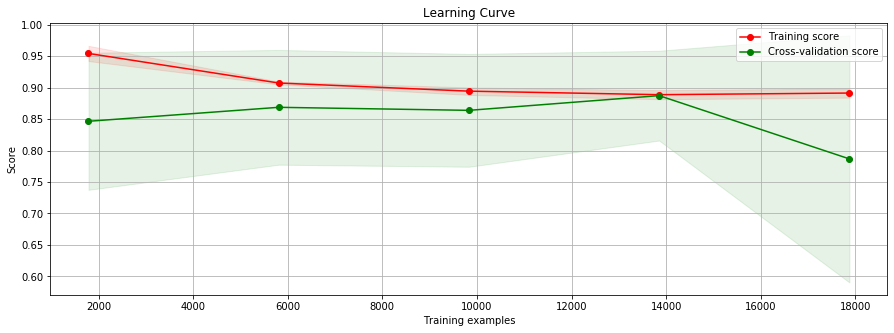

In [25]:
plot_model_char(model)

In [26]:
X, y, feats = get_feats_X_y(train_group)
m = XGBClassifier(**xgb_params)
m.fit(X,y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.1208 ± 0.0041,price_total_log
0.0480 ± 0.0019,prc_customer_cancel
0.0408 ± 0.0024,prc_product_cancel
0.0130 ± 0.0014,customer_id
0.0072 ± 0.0010,stock_code
0.0015 ± 0.0006,cnt_product_cancel_log
0.0015 ± 0.0006,cnt_customer_cancel_log
0.0008 ± 0.0003,invoice
0.0007 ± 0.0004,cnt_customer_orders_log
0.0005 ± 0.0003,cnt_product_orders_log


In [47]:
def fit_and_predict_test(model, df):
    cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
    return cross_val_predict(model, df[feats], df['is_canceled'], cv=cv)

In [57]:
def pred_proba_SKFold(df, xgb_params):
        X, y, feats = get_feats_X_y(df)
        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
        df['predict_proba'] = np.nan
        scores = []
        for train_idx, test_idx in cv.split(X, y):
            model = XGBClassifier(**xgb_params)
            model.fit(X[train_idx], y[train_idx])
            df['predict_proba'].iloc[test_idx] = [x[1] for x in model.predict_proba(X[test_idx])]

In [59]:
# calculate mse on train xgb_params_opt_small  is_canceled_pred total_return total_return_pred
treshold = 0.7

model = XGBClassifier(**xgb_params)
if treshold is None:
    train_group['is_canceled_pred'] = fit_and_predict_test(model, train_group)
else:
    train_group['is_canceled_pred'] = train_group['predict_proba'].map(lambda x: True if x > treshold else False)
    
train_group['total_return'] = train_group['price_total'] * train_group['is_canceled']
train_group['total_return_pred'] = train_group['price_total'] * train_group['is_canceled_pred']



score = mean_squared_error(train_group['total_return'], train_group['total_return_pred'])
print(score)

# train_group['right_pred'] = train_group[['is_canceled', 'is_canceled_pred']].apply(lambda x: x['is_canceled'] == x['is_canceled_pred'], axis=1)
# train_group.groupby('right_pred')['price_total'].agg(np.sum) / train_group.groupby('right_pred')['price_total'].agg(np.size)

1408996.6


In [66]:
train_group['msae'] = train_group[['total_return', 'total_return_pred']].apply(lambda x: mean_squared_error([x['total_return']], [x['total_return_pred']]), axis=1)

In [67]:
train_group

,invoice,customer_id,invoice_year,invoice_day_of_y,invoice_hour,cnt_customer_orders,cnt_customer_cancel,prc_customer_cancel,cnt_product_orders,cnt_product_cancel,...,cnt_customer_orders_log,cnt_customer_cancel_log,cnt_product_orders_log,cnt_product_cancel_log,price_total_log,is_canceled_pred,total_return,total_return_pred,predict_proba,msae
0,2,1,2009,335,9,366.0,30.0,0.081967,460.157895,5.578947,...,5.905362,3.433987,6.133740,1.883875,6.447829,False,0.0,0.0,0.060842,0.0
1,3,2,2009,335,9,40.0,0.0,0.000000,291.260870,4.391304,...,3.713572,0.000000,5.677647,1.684787,5.742202,False,0.0,0.0,0.003593,0.0
2,4,3,2009,335,9,498.0,3.0,0.006024,193.764706,1.941176,...,6.212606,1.386294,5.271792,1.078810,7.735101,False,0.0,0.0,0.046702,0.0
3,5,4,2009,335,9,575.0,0.0,0.000000,423.947368,18.157895,...,6.356108,0.000000,6.051965,2.952715,6.057487,False,0.0,0.0,0.004404,0.0
4,8,6,2009,335,9,101.0,1.0,0.009901,411.217391,5.739130,...,4.624973,0.693147,6.021551,1.907931,5.949000,False,0.0,0.0,0.036438,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26810,53621,385,2011,343,12,3633.0,35.0,0.009634,262.166667,3.125000,...,8.198089,3.583519,5.572788,1.417066,4.555034,False,0.0,0.0,0.011910,0.0
26811,53623,122,2011,343,12,253.0,22.0,0.086957,875.000000,19.500000,...,5.537334,3.135494,6.775366,3.020425,4.833102,False,0.0,0.0,0.104089,0.0
26812,53624,122,2011,343,12,253.0,22.0,0.086957,145.500000,1.000000,...,5.537334,3.135494,4.987025,0.693147,4.953289,False,0.0,0.0,0.091335,0.0
26813,53625,4982,2011,343,12,71.0,2.0,0.028169,420.619048,6.238095,...,4.276666,1.098612,6.044102,1.979358,5.799244,False,0.0,0.0,0.005125,0.0


In [68]:
train_group[['predict_proba', 'is_canceled_pred', 'msae']].sample(20)

,predict_proba,is_canceled_pred,msae
7910,0.030281,False,0.00000
7620,0.003532,False,0.00000
3052,0.003677,False,0.00000
8056,0.003532,False,0.00000
8840,0.462916,False,162650.90625
17006,0.003534,False,0.00000
24104,0.003464,False,0.00000
19620,0.028076,False,0.00000
24584,0.010198,False,0.00000
11895,0.022981,False,0.00000


# Hyper opt

In [40]:
def hyperOptf1(train):
    X, y, feats = get_feats_X_y(train)


    def objective(space):

        xgb_params = {
            'max_depth': int(space['max_depth']),
            'colsample_bytree': space['colsample_bytree'],
            'learning_rate': space['learning_rate'],
            'subsample': space['subsample'],
            'min_child_weight': int(space['min_child_weight']),
            'reg_alpha': space['reg_alpha'],
            'reg_lambda': space['reg_lambda'],
            'n_estimators': int(space['n_estimators']),
            'objective': 'reg:squarederror',
            'seed':0
        }
        
        
#         cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)
#         scores = cross_val_score(model, X, y, cv=cv, scoring='recall')

#         final_score = 1 - np.mean(scores)


        cv = StratifiedKFold(n_splits=3, random_state=0, shuffle=True)

        scores = []
        for train_idx, test_idx in cv.split(X, y):
            model = XGBClassifier(**xgb_params)
            model.fit(X[train_idx], y[train_idx])
            y_pred = model.predict(X[test_idx])
            
            score = mean_squared_error(y_pred * train['total_return'].iloc[test_idx], train['total_return'].iloc[test_idx])
            scores.append(score)

        final_score = np.mean(scores)

            
#         print('\n xgb_params: {}'.format(xgb_params))
#         print('scores: {}'.format(scores))
        print('final_score: {}'.format(final_score))
        return{'loss':final_score, 'status': STATUS_OK }

    space ={
        'max_depth': hp.quniform ('max_depth', 5, 20, 1),
        'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
        'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
        'subsample': hp.uniform ('subsample', 0.7, 1.),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'reg_alpha': hp.loguniform ('reg_alpha', 0., 1.),
        'reg_lambda': hp.uniform ('reg_lambda', 0.7, 1.),
        'n_estimators': hp.quniform('n_estimators', 50, 1000, 1)
    }


    trials = Trials()
    best_params = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=10),
                max_evals=30,
                trials=trials)

    print("The best params: ", best_params)

In [41]:
train_small['total_return'] = train_small['price_total'] * train_small['is_canceled']
train_big['total_return'] = train_big['price_total'] * train_big['is_canceled']

hyperOptf1(train_small)
hyperOptf1(train_big)

final_score: 1722.3311767578125                       
final_score: 1805.3895263671875                                                 
final_score: 1736.4332275390625                                                 
final_score: 1853.041015625                                                     
final_score: 1678.5716552734375                                                 
final_score: 1653.125                                                           
final_score: 1745.3192138671875                                                 
final_score: 1714.91162109375                                         
final_score: 1726.3662109375                                          
final_score: 1765.27197265625                                         
final_score: 1931.2923583984375                                        
final_score: 1805.685546875                                            
final_score: 1875.99853515625                                          
final_score: 1793.363891601562

In [35]:
xgb_params_opt_small = {'colsample_bytree': 0.9981611944815248, 'learning_rate': 0.2241583433345212, 'max_depth': 15, 'min_child_weight': 9, 'n_estimators': 178, 'reg_alpha': 1.3883886775407488, 'reg_lambda': 0.7417205774366255, 'subsample': 0.7897486170702018}
xgb_params_opt_big = {'colsample_bytree': 0.8035738679874582, 'learning_rate': 0.05290139403626696, 'max_depth': 19, 'min_child_weight': 10, 'n_estimators': 52, 'reg_alpha': 2.703316303992346, 'reg_lambda': 0.7038526356090737, 'subsample': 0.9997761787157459}

In [46]:
# final predict two models

X, y, feats = get_feats_X_y(train_small)

model = XGBClassifier(**xgb_params_opt_small)
model.fit(train_small[feats], train_small['is_canceled'])
test_small['is_canceled'] = model.predict(test_small[feats])

model = XGBClassifier(**xgb_params_opt_big)
model.fit(train_big[feats], train_big['is_canceled'])
test_big['is_canceled'] = model.predict(test_big[feats])

test_all = pd.concat([test_small, test_big], sort=False)

In [48]:
#prepare submit
test_all['total_return'] = test_all['price_total'] * test_all['is_canceled']
test_all[ ['invoice', 'total_return'] ].to_csv('../../../output/xgb_and_cnt_features.csv', index=False)